<a href="https://colab.research.google.com/github/mamonalsalihy/Emotion_Detection/blob/main/LIWC_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statements

In [3]:
from tqdm.auto import tqdm
import os
import pandas as pd
import csv
import pickle as pkl
import nltk
import matplotlib.pyplot as plt
import seaborn as sea
import re
import os
import spacy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import math
from itertools import chain

import gensim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Open Dataset

In [4]:
with open("train.csv", "r") as intrain: 
    train = pd.read_csv(intrain)
with open("valid.csv", "r") as indev: 
    valid = pd.read_csv(indev)
with open("test.csv", "r") as intest: 
    test = pd.read_csv(intest)
print(train)

               conv_id  utterance_idx  ... Sleeping Grooming
0         hit:0_conv:1              1  ...      0.0      0.0
1         hit:0_conv:1              2  ...      0.0      0.0
2         hit:0_conv:1              3  ...      0.0      0.0
3         hit:0_conv:1              4  ...      0.0      0.0
4         hit:0_conv:1              5  ...      0.0      0.0
...                ...            ...  ...      ...      ...
1176  hit:145_conv:291              6  ...      0.0      0.0
1177  hit:145_conv:291              7  ...      0.0      0.0
1178  hit:148_conv:296              1  ...      0.0      0.0
1179  hit:148_conv:296              2  ...      0.0      0.0
1180  hit:148_conv:296              3  ...      NaN      NaN

[1181 rows x 93 columns]


#LIWC Visuals

##Emotion Labels

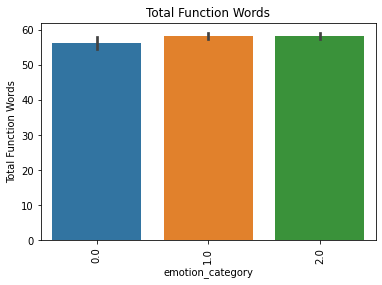

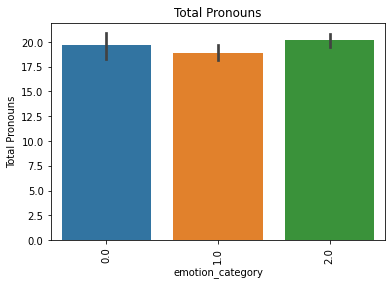

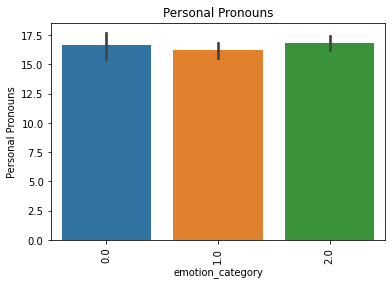

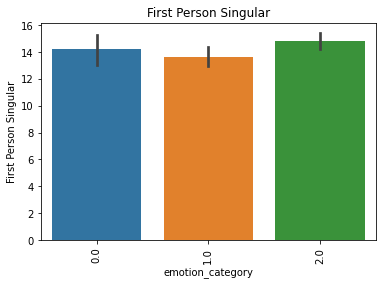

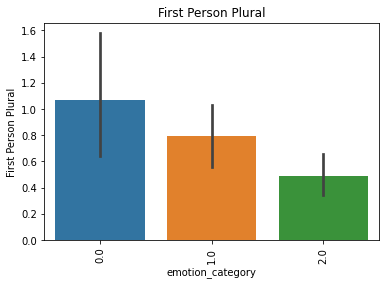

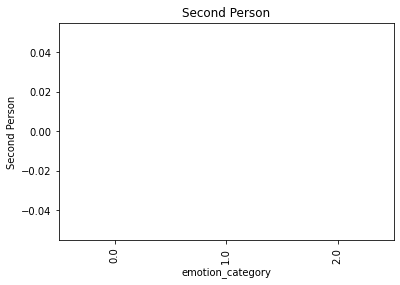

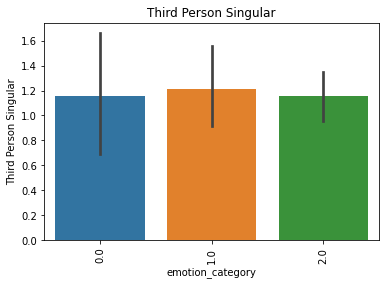

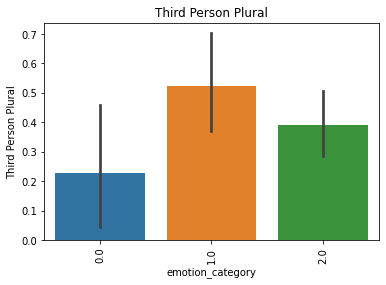

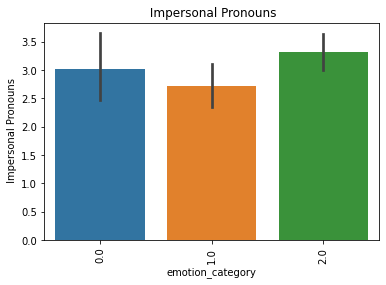

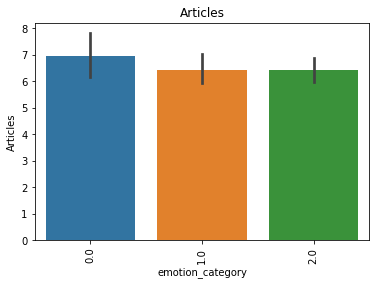

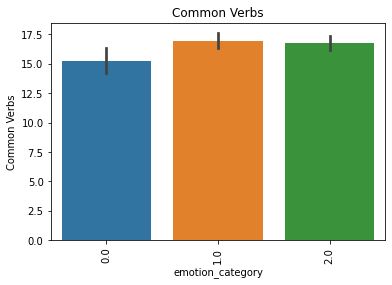

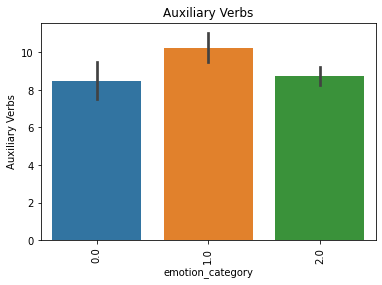

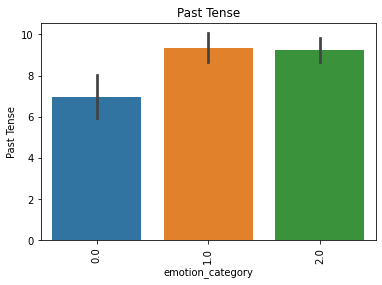

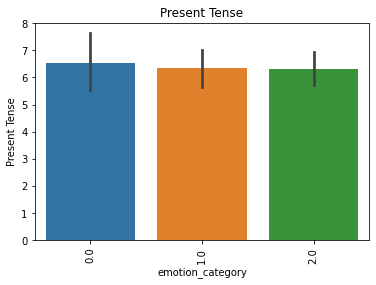

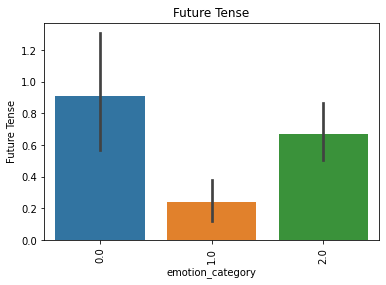

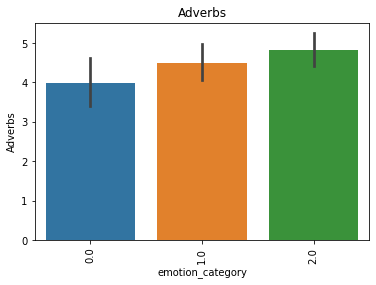

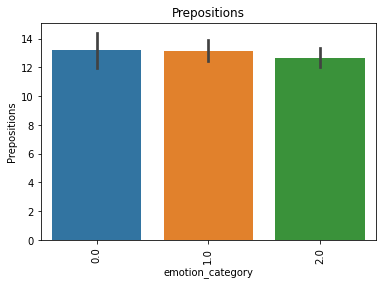

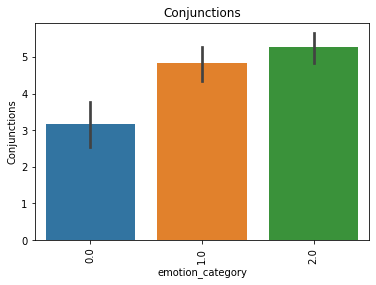

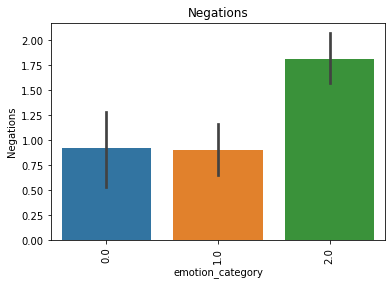

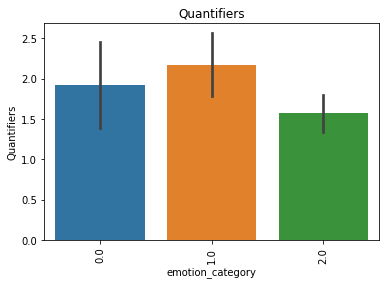

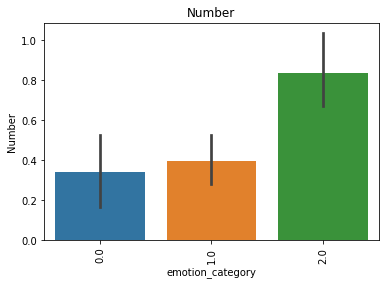

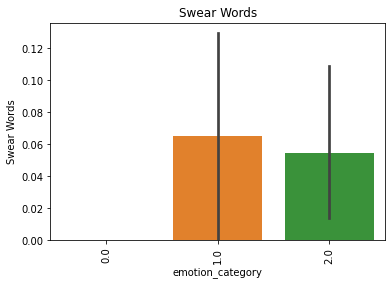

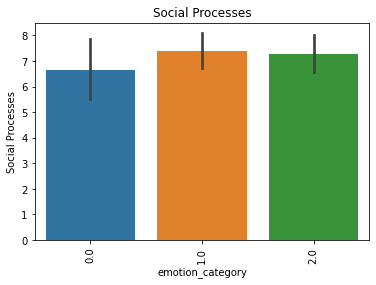

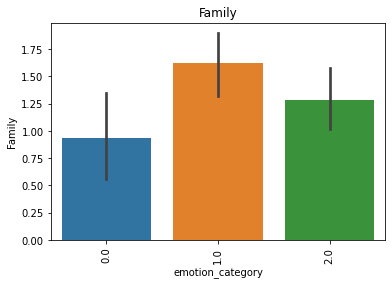

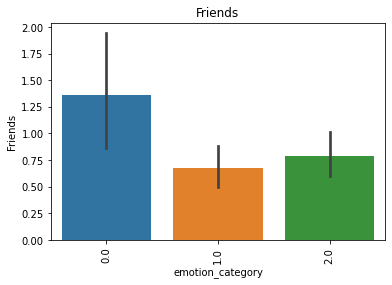

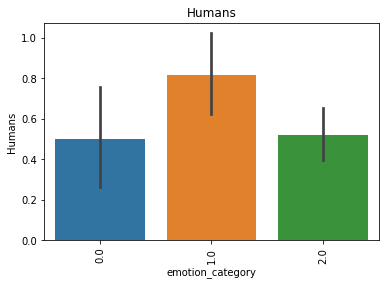

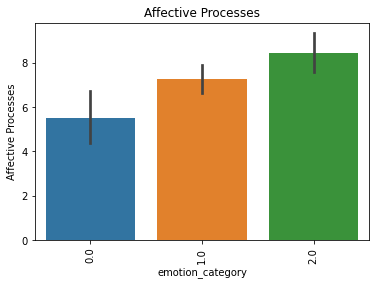

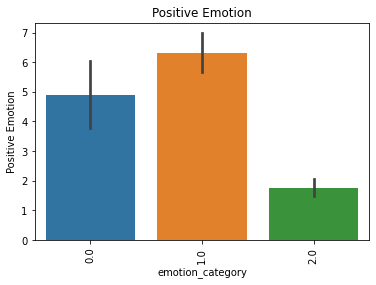

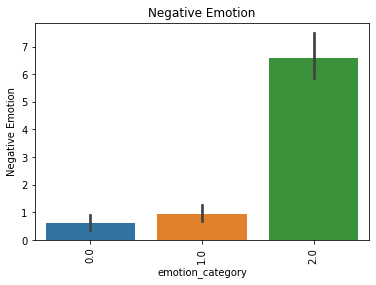

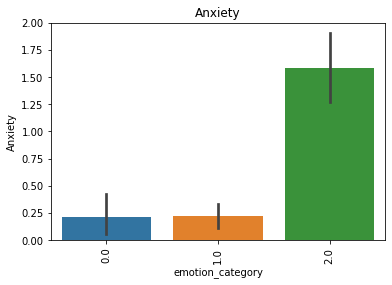

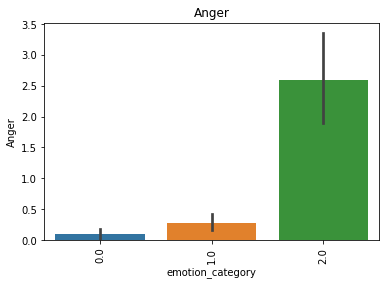

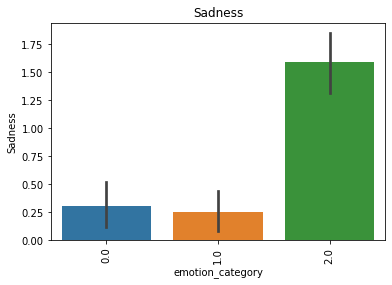

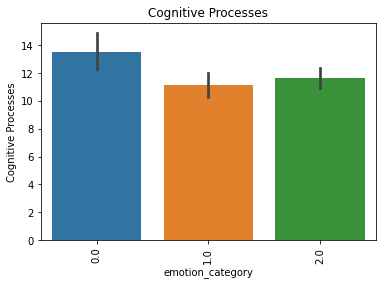

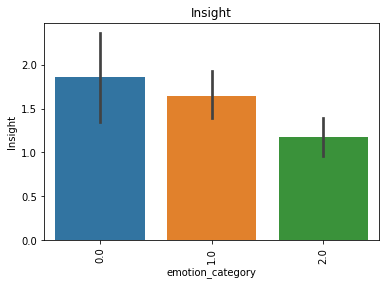

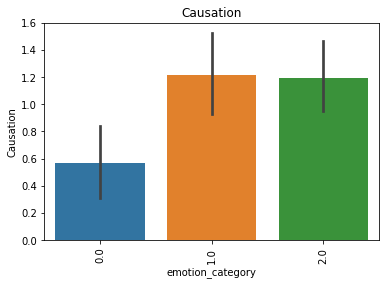

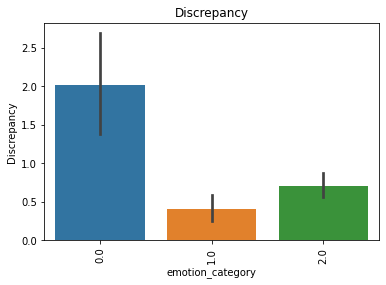

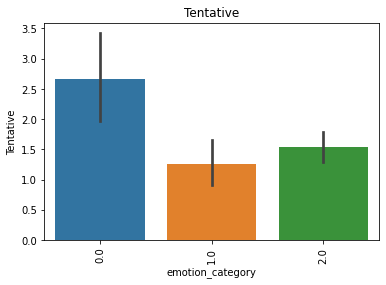

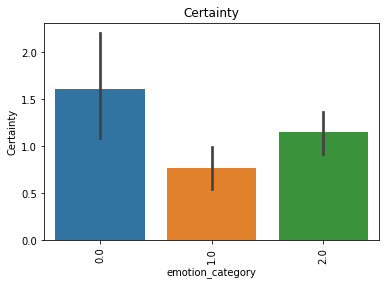

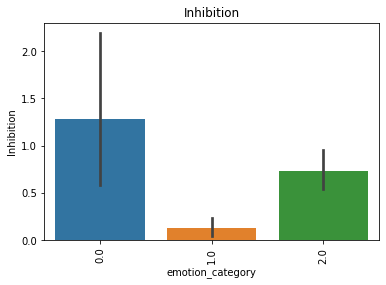

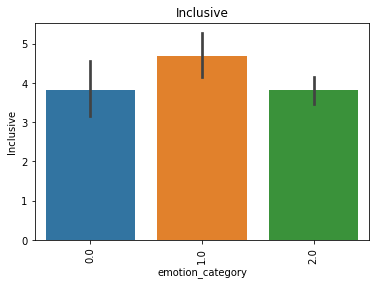

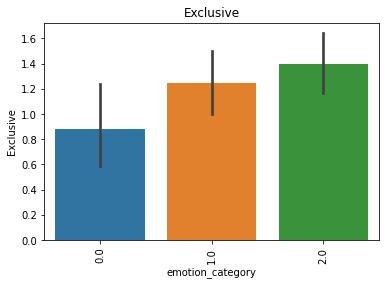

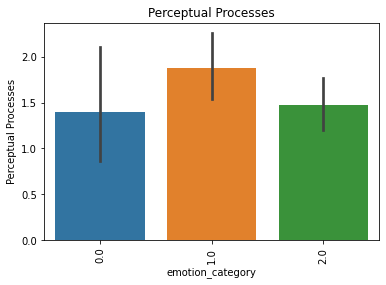

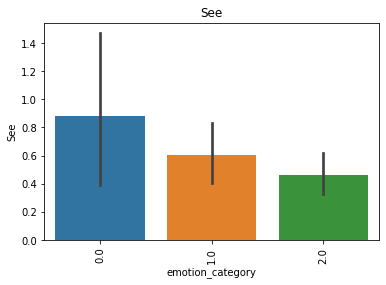

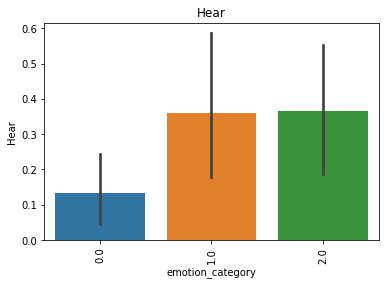

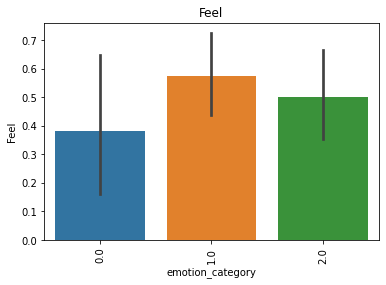

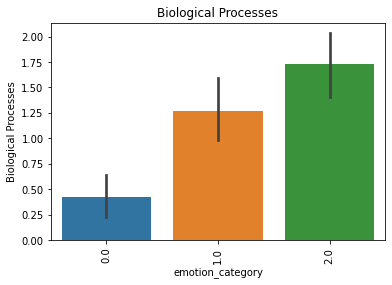

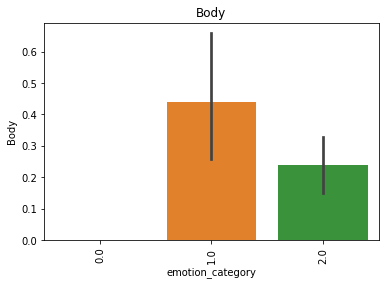

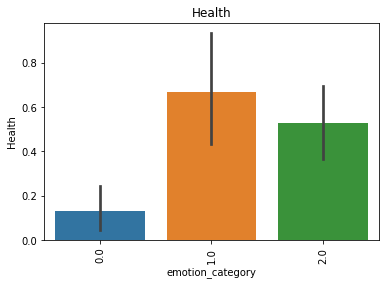

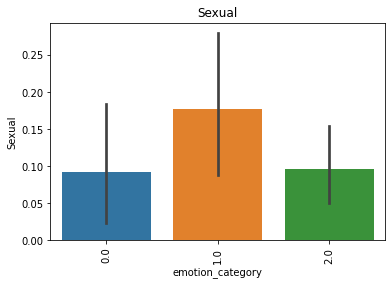

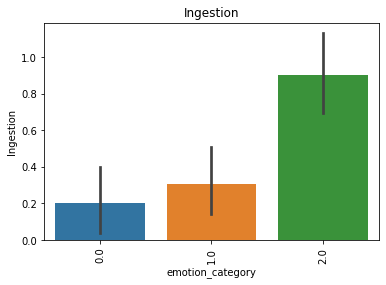

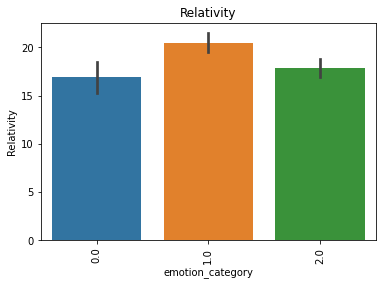

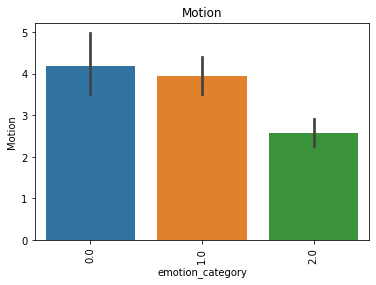

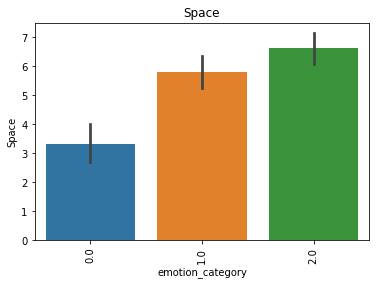

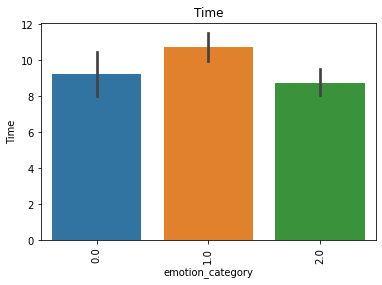

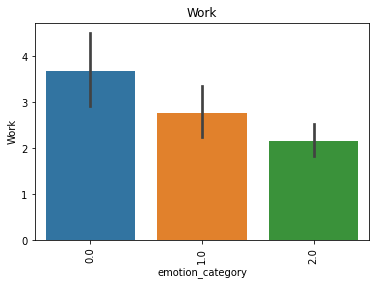

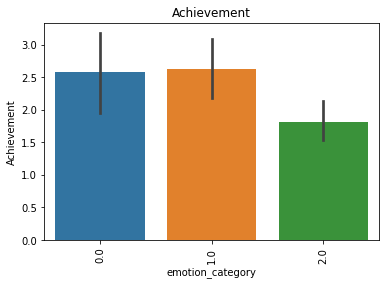

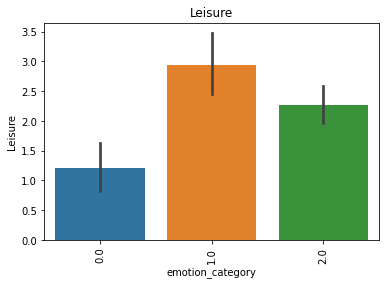

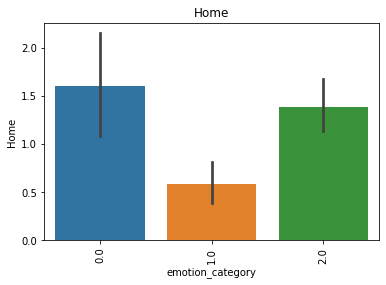

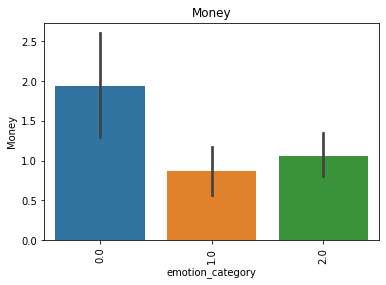

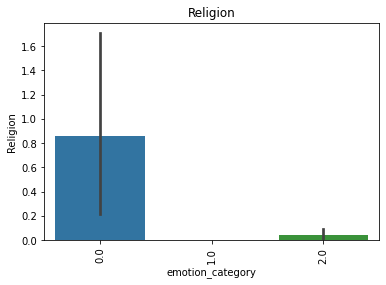

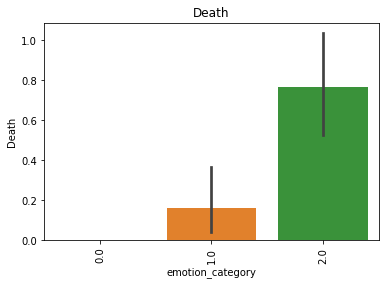

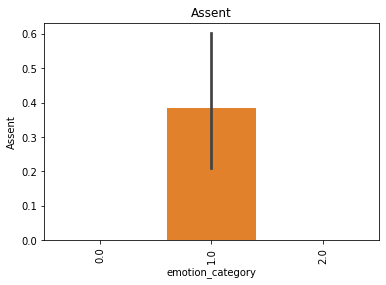

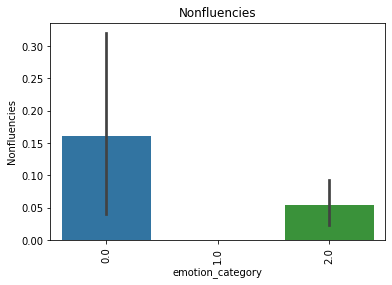

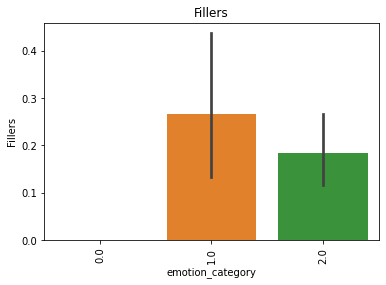

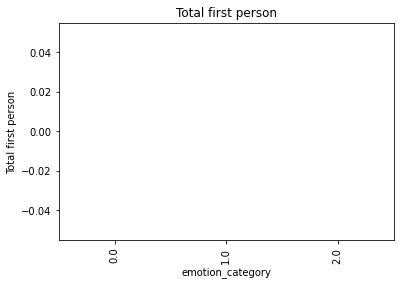

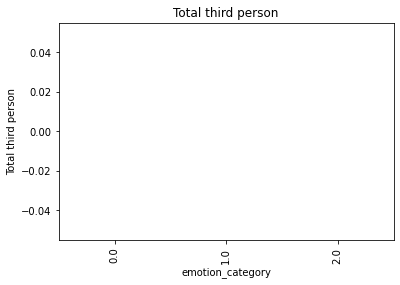

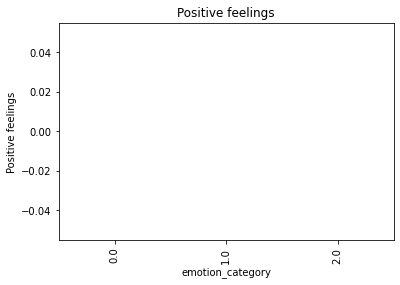

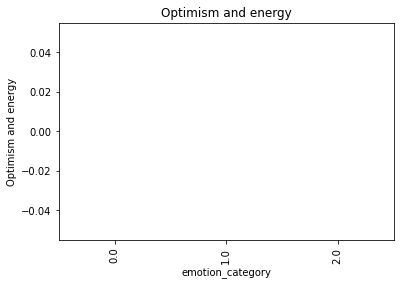

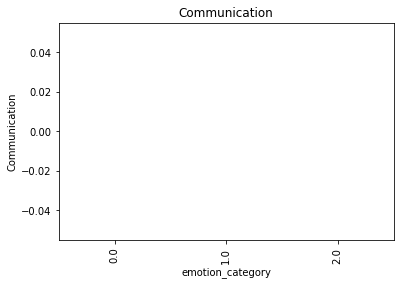

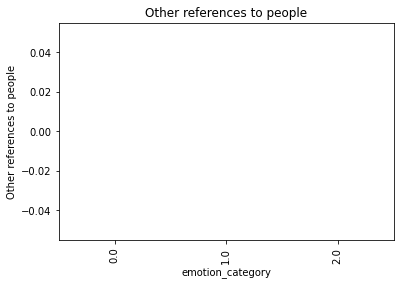

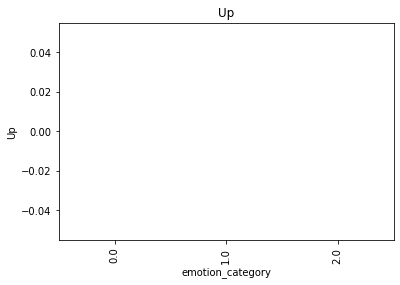

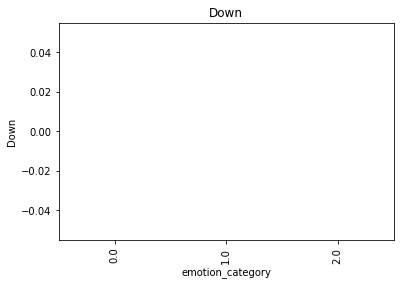

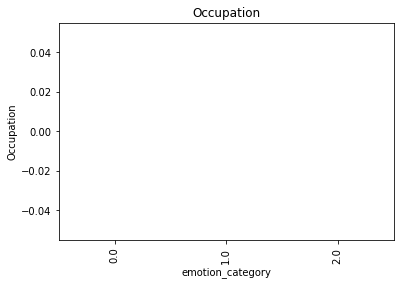

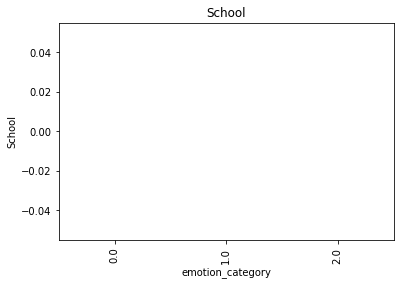

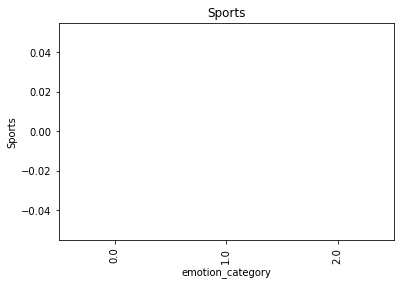

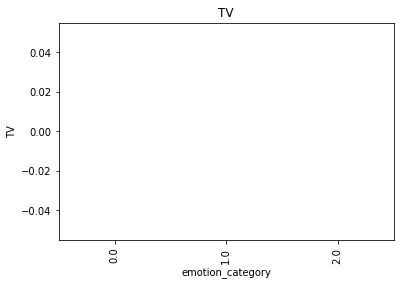

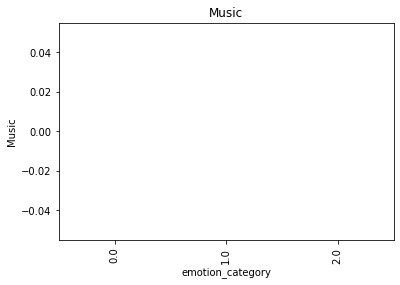

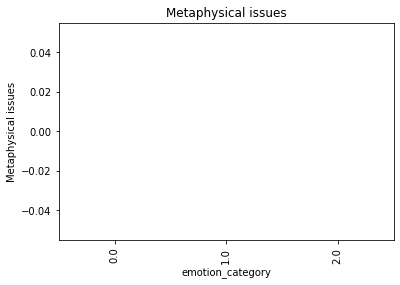

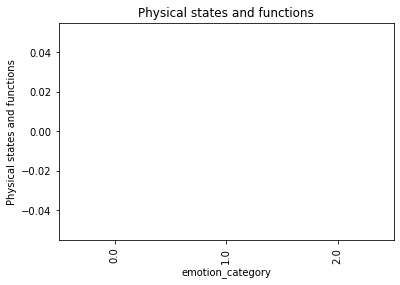

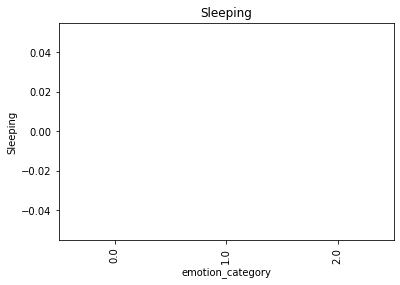

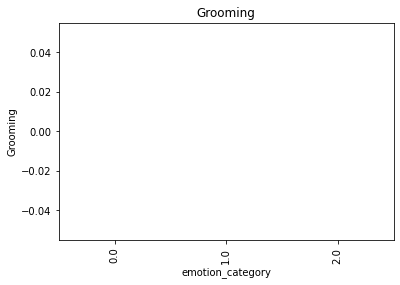

In [5]:
# Some distribution contain no liwc features hence we have empty graphs.
_liwc_categories = [
          ('Total Function Words', 1, 'funct', None, None),
          ('Total Pronouns', 2, 'pronoun', 1, 'pronoun'),
          ('Personal Pronouns', 3, 'ppron', None, None),
          ('First Person Singular', 4, 'i', 2, 'i'),
          ('First Person Plural', 5, 'we', 3, 'we'),
          ('Second Person', 6, 'you', 5, 'you'),
          ('Third Person Singular', 7, 'shehe', None, None),
          ('Third Person Plural', 8, 'they', None, None),
          (' Impersonal Pronouns', 9, 'ipron', None, None),
          ('Articles', 10, 'article', 9, 'article'),
          ('Common Verbs', 11, 'verb', None, None),
          ('Auxiliary Verbs', 12, 'auxverb', None, None),
          ('Past Tense', 13, 'past', 38, 'past'),
          ('Present Tense', 14, 'present', 39, 'present'),
          ('Future Tense', 15, 'future', 40, 'future'),
          ('Adverbs', 16, 'adverb', None, None),
          ('Prepositions', 17, 'preps', 10, 'preps'),
          ('Conjunctions', 18, 'conj', None, None),
          ('Negations', 19, 'negate', 7, 'negate'),
          ('Quantifiers', 20, 'quant', None, None),
          ('Number', 21, 'number', 11, 'number'),
          ('Swear Words', 22, 'swear', 66, 'swear'),
          ('Social Processes', 121, 'social', 31, 'social'),
          ('Family', 122, 'family', 35, 'family'),
          ('Friends', 123, 'friend', 34, 'friends'),
          ('Humans', 124, 'humans', 36, 'humans'),
          ('Affective Processes', 125, 'affect', 12, 'affect'),
          ('Positive Emotion', 126, 'posemo', 13, 'posemo'),
          ('Negative Emotion', 127, 'negemo', 16, 'negemo'),
          ('Anxiety', 128, 'anx', 17, 'anx'),
          ('Anger', 129, 'anger', 18, 'anger'),
          ('Sadness', 130, 'sad', 19, 'sad'),
          ('Cognitive Processes', 131, 'cogmech', 20, 'cogmech'),
          ('Insight', 132, 'insight', 22, 'insight'),
          ('Causation', 133, 'cause', 21, 'cause'),
          ('Discrepancy', 134, 'discrep', 23, 'discrep'),
          ('Tentative', 135, 'tentat', 25, 'tentat'),
          ('Certainty', 136, 'certain', 26, 'certain'),
          ('Inhibition', 137, 'inhib', 24, 'inhib'),
          ('Inclusive', 138, 'incl', 44, 'incl'),
          ('Exclusive', 139, 'excl', 45, 'excl'),
          ('Perceptual Processes', 140, 'percept', 27, 'senses'),
          ('See', 141, 'see', 28, 'see'),
          ('Hear', 142, 'hear', 29, 'hear'),
          ('Feel', 143, 'feel', 30, 'feel'),
          ('Biological Processes', 146, 'bio', None, None),
          ('Body', 147, 'body', 61, 'body'),
          ('Health', 148, 'health', None, None),
          ('Sexual', 149, 'sexual', 62, 'sexual'),
          ('Ingestion', 150, 'ingest', 63, 'eating'),
          ('Relativity', 250, 'relativ', None, None),
          ('Motion', 251, 'motion', 46, 'motion'),
          ('Space', 252, 'space', 41, 'space'),
          ('Time', 253, 'time', 37, 'time'),
          ('Work', 354, 'work', 49, 'job'),
          ('Achievement', 355, 'achieve', 50, 'achieve'),
          ('Leisure', 356, 'leisure', 51, 'leisure'),
          ('Home', 357, 'home', 52, 'home'),
          ('Money', 358, 'money', 56, 'money'),
          ('Religion', 359, 'relig', 58, 'relig'),
          ('Death', 360, 'death', 59, 'death'),
          ('Assent', 462, 'assent', 8, 'assent'),
          ('Nonfluencies', 463, 'nonfl', 67, 'nonfl'),
          ('Fillers', 464, 'filler', 68, 'fillers'),
          ('Total first person', None, None, 4, 'self'),
          ('Total third person', None, None, 6, 'other'),
          ('Positive feelings', None, None, 14, 'posfeel'),
          ('Optimism and energy', None, None, 15, 'optim'),
          ('Communication', None, None, 32, 'comm'),
          ('Other references to people', None, None, 33, 'othref'),
          ('Up', None, None, 42, 'up'),
          ('Down', None, None, 43, 'down'),
          ('Occupation', None, None, 47, 'occup'),
          ('School', None, None, 48, 'school'),
          ('Sports', None, None, 53, 'sports'),
          ('TV', None, None, 54, 'tv'),
          ('Music', None, None, 55, 'music'),
          ('Metaphysical issues', None, None, 57, 'metaph'),
          ('Physical states and functions', None, None, 60, 'physcal'),
          ('Sleeping', None, None, 64, 'sleep'),
          ('Grooming', None, None, 65, 'groom')]
cat = []
for i in _liwc_categories:    
    sea.barplot(x="emotion_category", y=i[0], data=train)
    plt.xticks(rotation = 90)
    plt.title(i[0])
    plt.show()
    cat.append(i[0])


#Value Counts Visuals and Statistics

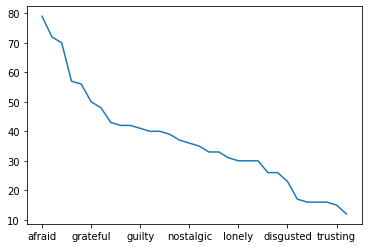

In [6]:
# Count distribution of the 32 labels (train)
train['context'].value_counts().plot()

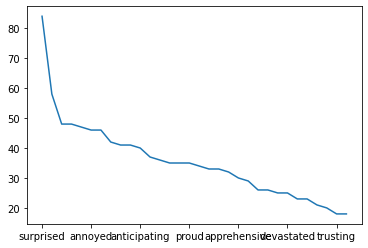

In [8]:
# Count distribution of 32 labels (valid)
valid['context'].value_counts().plot()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


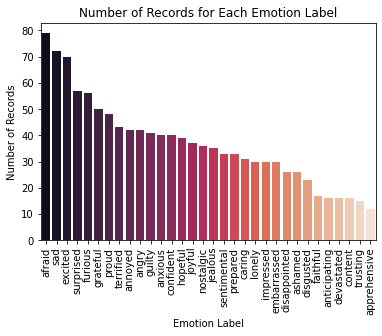

In [9]:
# Number of Records for Each Context

ax =sea.countplot("context", data=train, order=train["context"].value_counts().index,  palette="rocket")
#ax.set_xticklabels(train['context'], rotation=90, ha='right')
plt.xticks(rotation=90)
plt.title("Number of Records for Each Emotion Label")
plt.ylabel("Number of Records")
plt.xlabel("Emotion Label")
plt.savefig("value_counts.png")
plt.savefig("Fig.png", bbox_inches='tight')
#files.download("Fid.png")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


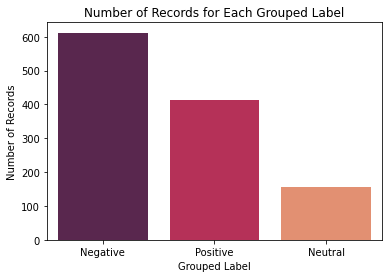

In [10]:
sea.countplot("emotion_category", data=train, order=train["emotion_category"].value_counts().index, palette="rocket")
plt.title("Number of Records for Each Grouped Label")
plt.xticks([2, 1, 0], [ "Neutral","Positive", "Negative"])
plt.ylabel("Number of Records")
plt.xlabel("Grouped Label")
plt.savefig("grouped_label.png")